In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam, RMSprop

plt.rc('font', family='Malgun Gothic') 

df = pd.read_csv("C:\\Users\\user\\jupyter\\traintest.csv")

데이터 전처리

In [15]:
df = pd.concat([df, pd.get_dummies(df['요일'])], axis=1)
df = df.sort_values('date').reset_index(drop=True)
df['date']=pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

def replace_zero_with_mean(df, column):
    for i in range(len(df)):
        if df[column][i] == 0:
            if i == 0:
                df.at[i, column] = (df[column][i+1] + df[column][i+2]) / 2
            elif i == len(df) - 1:
                df.at[i, column] = (df[column][i-1] + df[column][i-2]) / 2
            else:
                df.at[i, column] = (df[column][i-1] + df[column][i+1]) / 2

for column in df.columns:
    if '_가격(원/kg)' in column:
        replace_zero_with_mean(df, column)


stl = STL(df[['date', '사과_가격(원/kg)']].set_index('date'), period=12)
res = stl.fit()
df['resid'] = res.resid.values


모델링

- 가격예측

In [4]:
feature_columns = ['사과_거래량(kg)', 'year', 'month', 'day', '금요일', '목요일', '수요일', '월요일', '일요일', '토요일', '화요일', 'resid']
target_columns = ['사과_가격(원/kg)']
data = df[feature_columns + target_columns]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_X = scaled_data[:, :-1] 
scaled_Y = scaled_data[:, -1]

X_reshaped = np.reshape(scaled_X, (scaled_X.shape[0], 1, scaled_X.shape[1]))

X_train, X_test, Y_train, Y_test = train_test_split(X_reshaped, scaled_Y, test_size=0.25, random_state=42)


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=50, batch_size=32)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0900
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0270
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0289
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0242
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0225
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0257
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0234
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0243
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244
Epoch 16/50
30/30 ━

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Train MSE:  409102551374.5043
Train MAE:  493745.1169926618
Train RMSE:  639611.2501938222
Train R²:  0.3470501429371592
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test MSE:  425363165177.85114
Test MAE:  505961.77593361406
Test RMSE:  652198.7160197812
Test R²:  0.20134663232342354


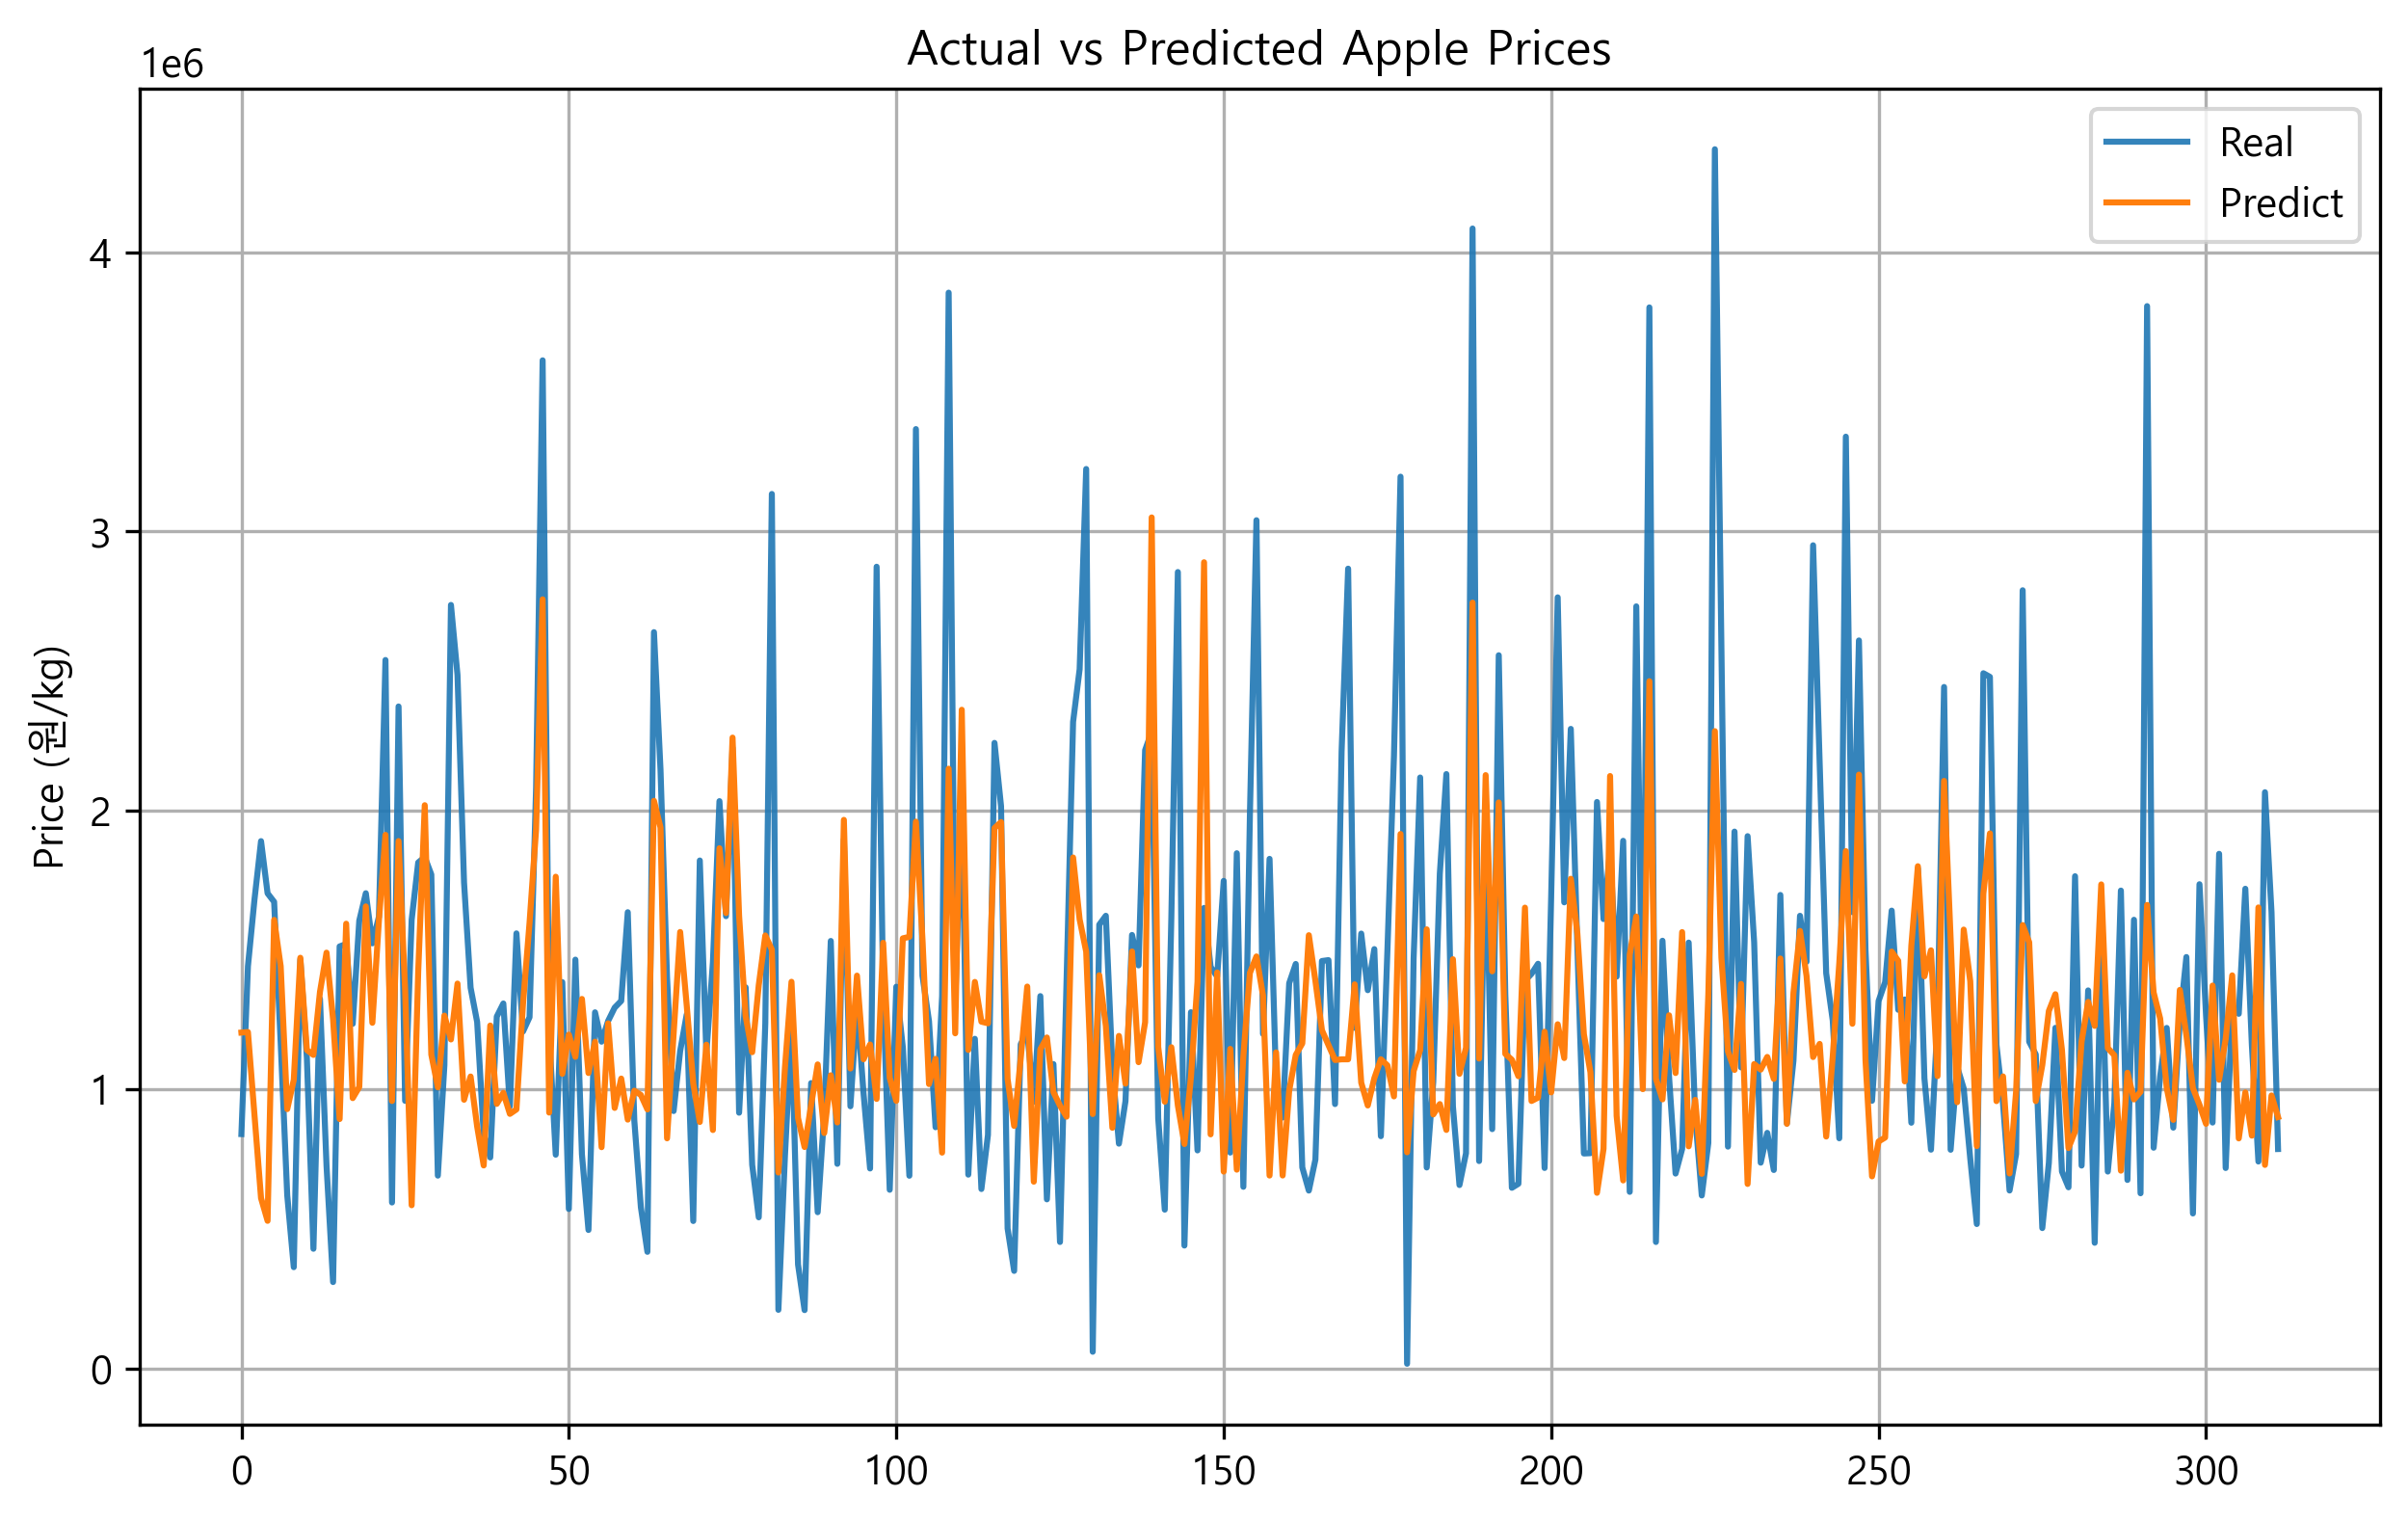

In [5]:
# Train
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, np.zeros((train_predictions.shape[0], len(feature_columns)))), axis=1))[:, 0]
Y_train_true = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], len(feature_columns)))), axis=1))[:, 0]

train_mse = mean_squared_error(Y_train_true, train_predictions)
train_mae = mean_absolute_error(Y_train_true, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(Y_train_true, train_predictions)

print("Train MSE: ", train_mse)
print("Train MAE: ", train_mae)
print("Train RMSE: ", train_rmse)
print("Train R²: ", train_r2)


# Test 
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], len(feature_columns)))), axis=1))[:, 0]
Y_test_true = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], len(feature_columns)))), axis=1))[:, 0]

test_mse = mean_squared_error(Y_test_true, test_predictions)
test_mae = mean_absolute_error(Y_test_true, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test_true, test_predictions)

print("Test MSE: ", test_mse)
print("Test MAE: ", test_mae)
print("Test RMSE: ", test_rmse)
print("Test R²: ", test_r2)

# 시각화 (Test 결과)
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(Y_test_true, alpha=0.9, label='Real')
plt.plot(test_predictions, label='Predict')
plt.title('Actual vs Predicted Apple Prices')
plt.ylabel('Price (원/kg)')
plt.legend()
plt.grid(True)
plt.show()


- 시퀀스 데이터 생성

In [6]:
feature_columns = ['사과_거래량(kg)', 'year', 'month', 'day', '금요일', '목요일', '수요일', '월요일', '일요일', '토요일', '화요일', 'resid']
target_columns = ['사과_가격(원/kg)']
data = df[feature_columns + target_columns]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

#시퀀스 데이터 생성 함수
def create_dataset(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :-1])
        Y.append(data[i + time_step, -1])
    return np.array(X), np.array(Y)

time_step = 7
X, Y = create_dataset(scaled_data, time_step)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=50, batch_size=32)


Epoch 1/50


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0539
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0255
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0285
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0281
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0223
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0240
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0225
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0203
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0193
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0207
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0175
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0237
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210
Epoch 16/50
30/30 ━━━━━━━━━━━━

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Train MSE:  122138944589.21053
Train MAE:  271881.4725836238
Train RMSE:  349483.8259336339
Train R²:  0.8074248780622264
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test MSE:  172059764169.89648
Test MAE:  305544.40656012134
Test RMSE:  414800.8729136144
Test R²:  0.6623746692828656


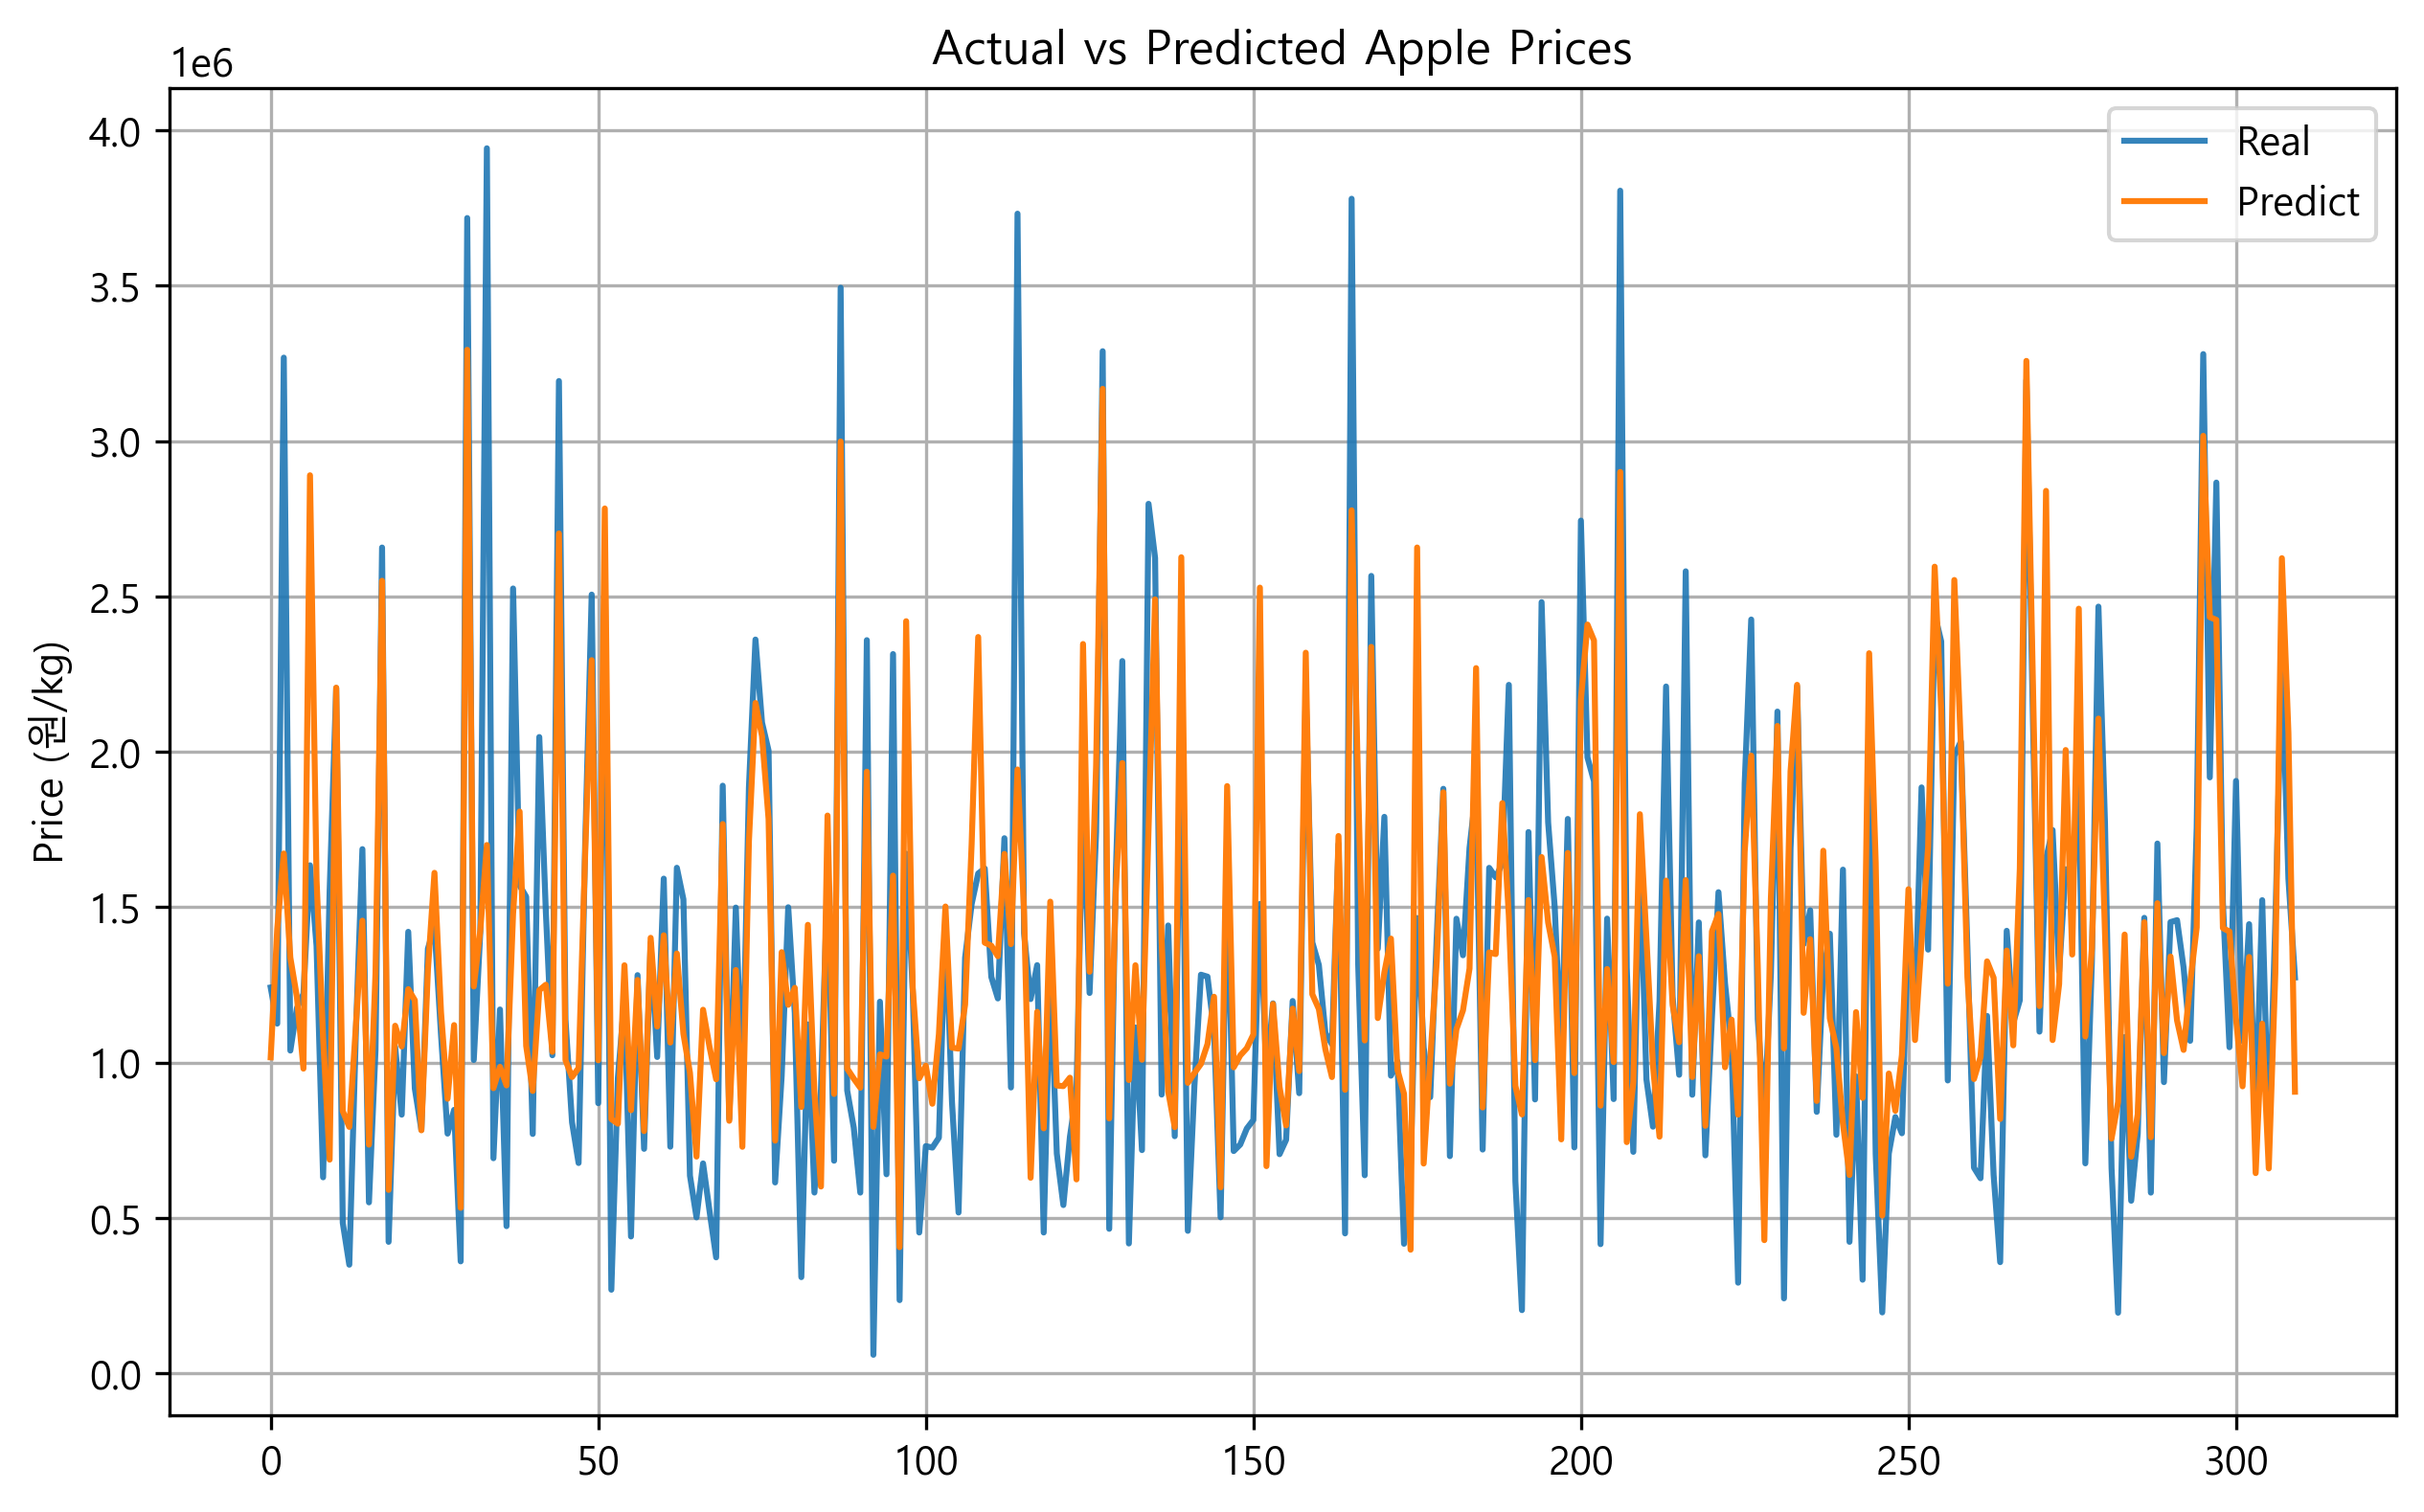

In [7]:
# Train
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, np.zeros((train_predictions.shape[0], len(feature_columns)))), axis=1))[:, 0]
Y_train_true = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], len(feature_columns)))), axis=1))[:, 0]

train_mse = mean_squared_error(Y_train_true, train_predictions)
train_mae = mean_absolute_error(Y_train_true, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(Y_train_true, train_predictions)

print("Train MSE: ", train_mse)
print("Train MAE: ", train_mae)
print("Train RMSE: ", train_rmse)
print("Train R²: ", train_r2)


# Test 
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], len(feature_columns)))), axis=1))[:, 0]
Y_test_true = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], len(feature_columns)))), axis=1))[:, 0]

test_mse = mean_squared_error(Y_test_true, test_predictions)
test_mae = mean_absolute_error(Y_test_true, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test_true, test_predictions)

print("Test MSE: ", test_mse)
print("Test MAE: ", test_mae)
print("Test RMSE: ", test_rmse)
print("Test R²: ", test_r2)

# 시각화 (Test 결과)
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(Y_test_true, alpha=0.9, label='Real')
plt.plot(test_predictions, label='Predict')
plt.title('Actual vs Predicted Apple Prices')
plt.ylabel('Price (원/kg)')
plt.legend()
plt.grid(True)
plt.show()


- 7일 후 가격 예측

In [4]:
df['target'] = df['사과_가격(원/kg)'].shift(-7)
df.dropna(subset=['target'], inplace=True)

target_columns = ['target']
feature_columns = ['사과_거래량(kg)', 'year', 'month', 'day', '금요일', '목요일', '수요일', '월요일', '일요일', '토요일', '화요일', 'resid']

data = df[feature_columns + target_columns]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


def create_dataset(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :-1])
        Y.append(data[i + time_step, -1])
    return np.array(X), np.array(Y)

time_step = 7
X, Y = create_dataset(scaled_data, time_step)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=50, batch_size=32)




c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0473
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0232
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0278
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0263
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0247
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0202
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197
Epoch 13/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187
Epoch 14/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184
Epoch 15/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175
Epoch 16/50
29/29 ━

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Train MSE:  197887809610.36893
Train MAE:  347565.3804170078
Train RMSE:  444845.82678762864
Train R²:  0.6844344603855417
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test MSE:  194576064308.99933
Test MAE:  341104.1597755918
Test RMSE:  441107.7694951647
Test R²:  0.6403574606938506


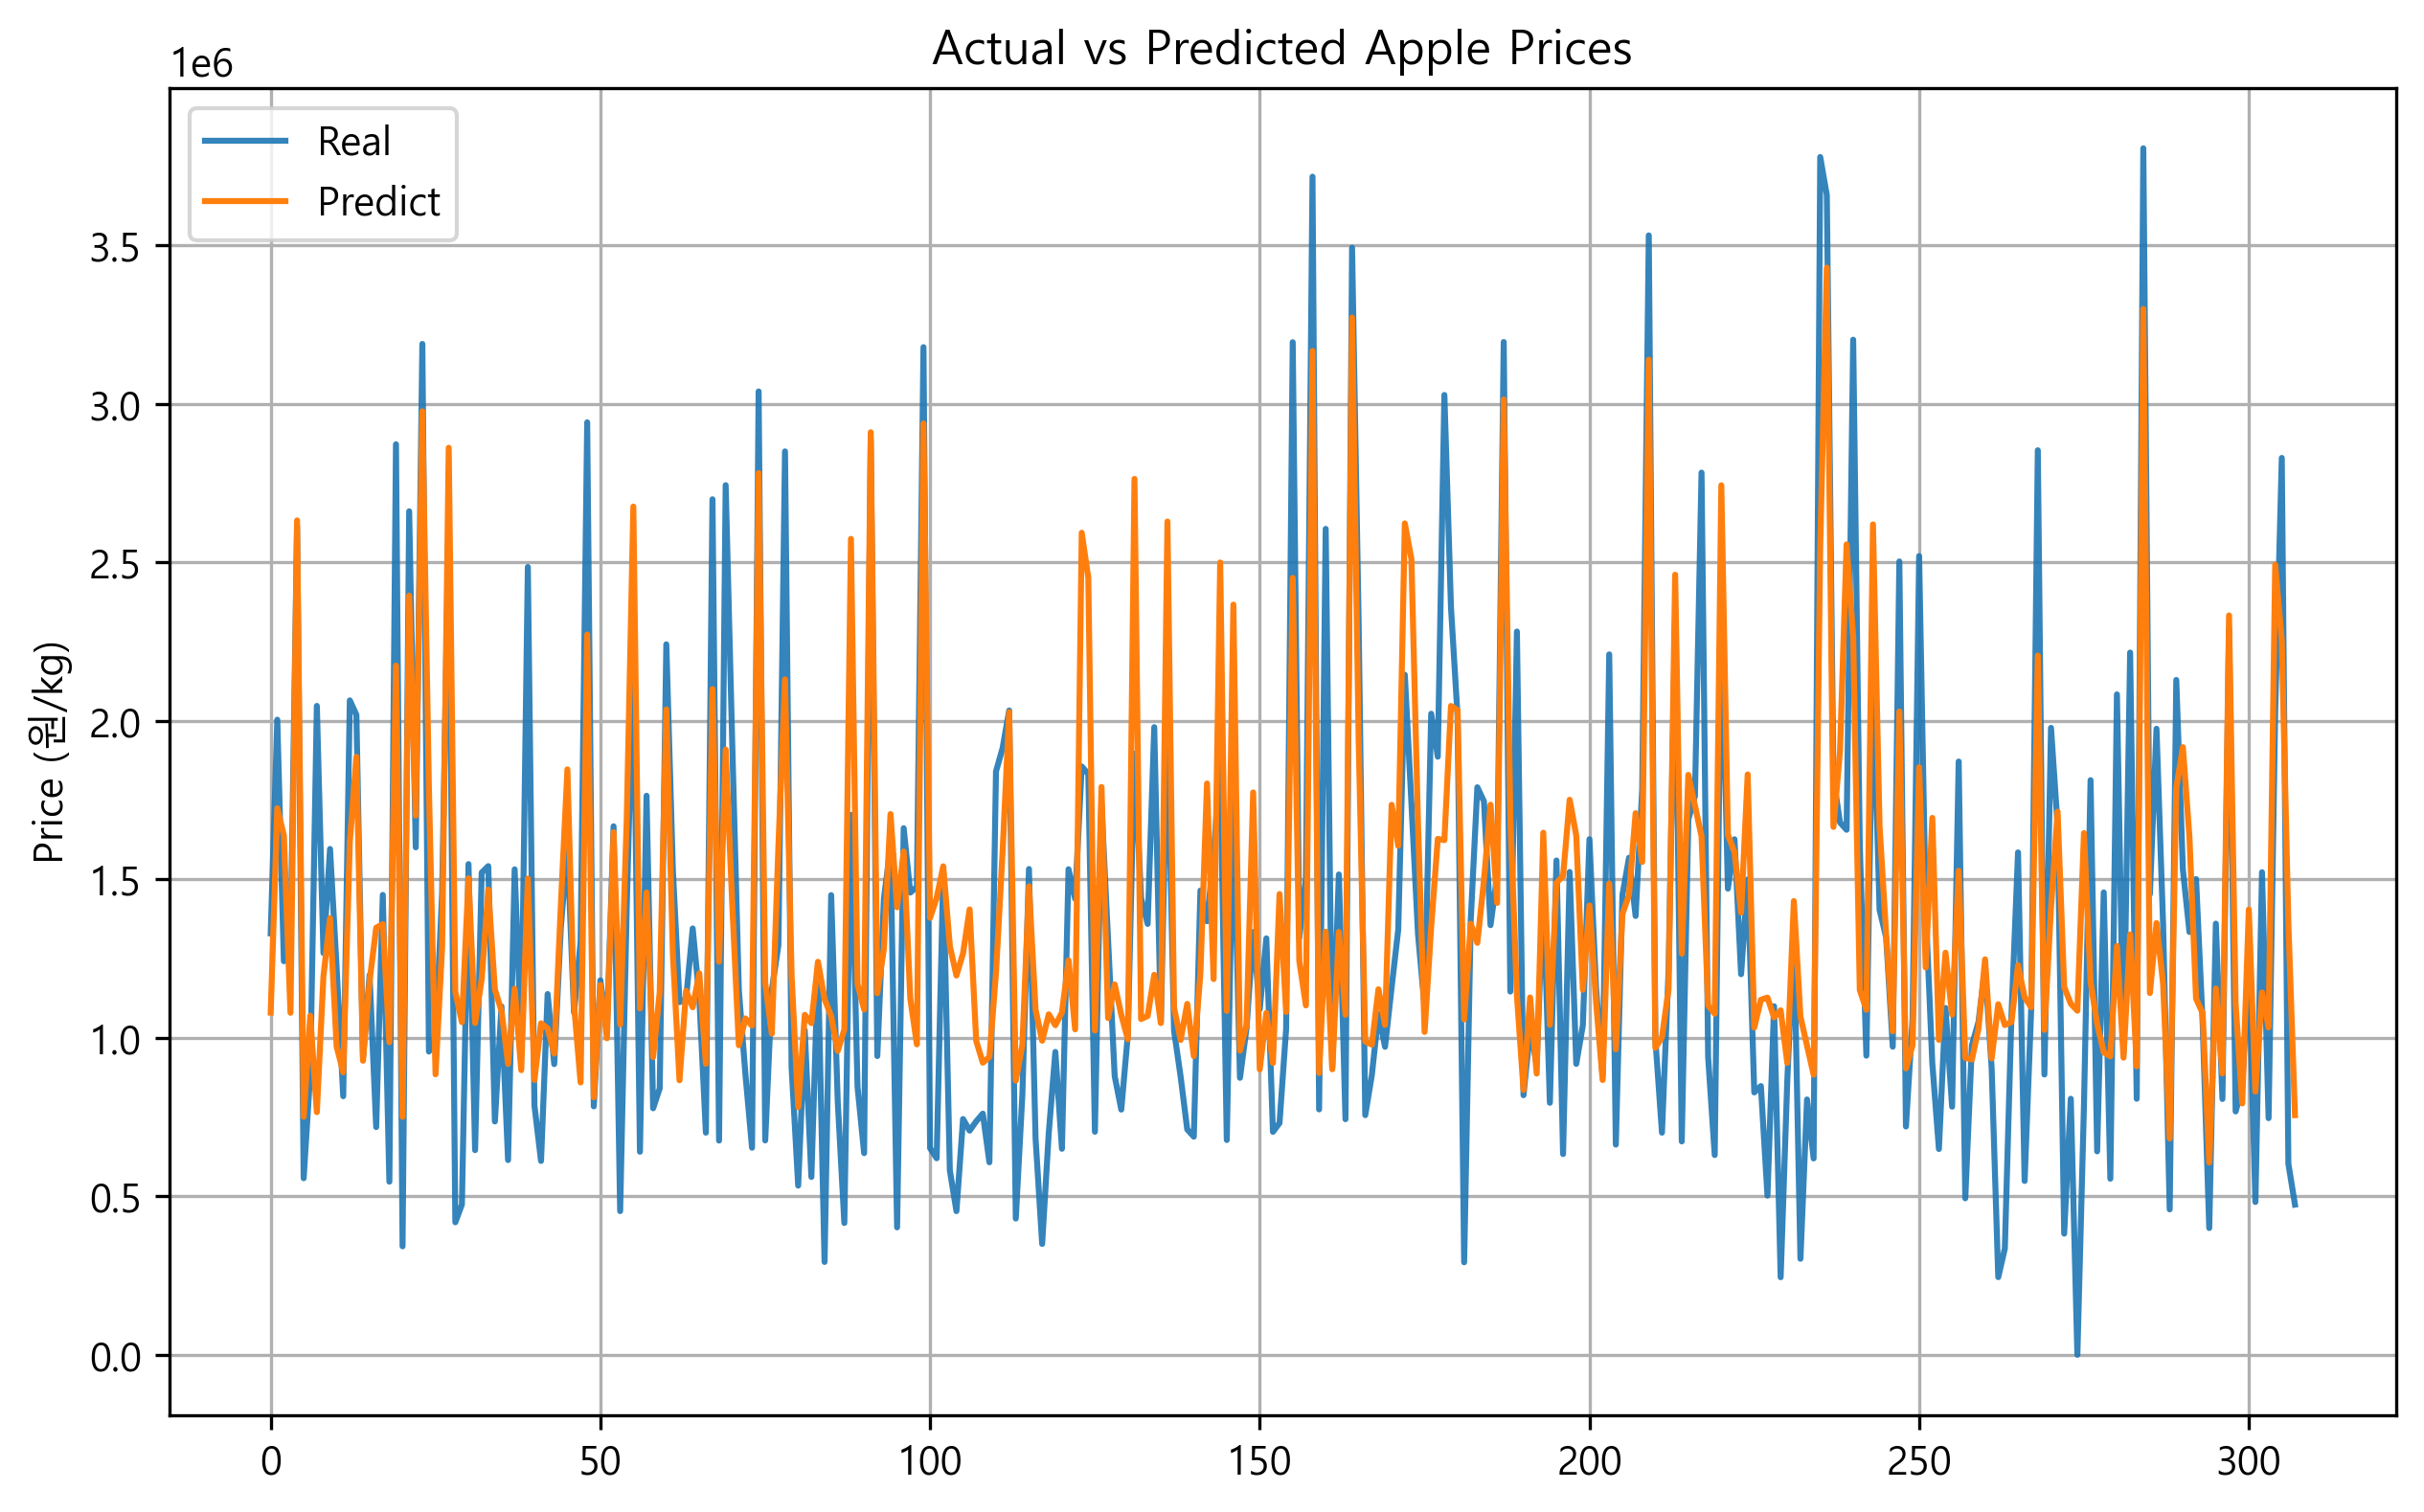

In [9]:
# Train
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, np.zeros((train_predictions.shape[0], len(feature_columns)))), axis=1))[:, 0]
Y_train_true = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], len(feature_columns)))), axis=1))[:, 0]

train_mse = mean_squared_error(Y_train_true, train_predictions)
train_mae = mean_absolute_error(Y_train_true, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(Y_train_true, train_predictions)

print("Train MSE: ", train_mse)
print("Train MAE: ", train_mae)
print("Train RMSE: ", train_rmse)
print("Train R²: ", train_r2)


# Test 
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], len(feature_columns)))), axis=1))[:, 0]
Y_test_true = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], len(feature_columns)))), axis=1))[:, 0]

test_mse = mean_squared_error(Y_test_true, test_predictions)
test_mae = mean_absolute_error(Y_test_true, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test_true, test_predictions)

print("Test MSE: ", test_mse)
print("Test MAE: ", test_mae)
print("Test RMSE: ", test_rmse)
print("Test R²: ", test_r2)

# 시각화 (Test 결과)
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(Y_test_true, alpha=0.9, label='Real')
plt.plot(test_predictions, label='Predict')
plt.title('Actual vs Predicted Apple Prices')
plt.ylabel('Price (원/kg)')
plt.legend()
plt.grid(True)
plt.show()


모델 개선

In [16]:
df['shifted_price'] = df['사과_가격(원/kg)'].shift(-7)
df.dropna(subset=['shifted_price'], inplace=True)

target_columns = ['shifted_price']
feature_columns = ['사과_거래량(kg)', 'year', 'month', 'day', '금요일', '목요일', '수요일', '월요일', '일요일', '토요일', '화요일', 'resid']

data = df[feature_columns + target_columns]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

def create_dataset(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :-1])
        Y.append(data[i + time_step, -1])
    return np.array(X), np.array(Y)

time_step = 7
X, Y = create_dataset(scaled_data, time_step)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dropout(0.1))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=0)





c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train MSE:  51349148253.65926
Train MAE:  163517.51916443298
Train RMSE:  226603.5045043639
Train R²:  0.919246727622683
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Test MSE:  70374038313.4647
Test MAE:  192124.8950238918
Test RMSE:  265281.0553233395
Test R²:  0.8585251590699109


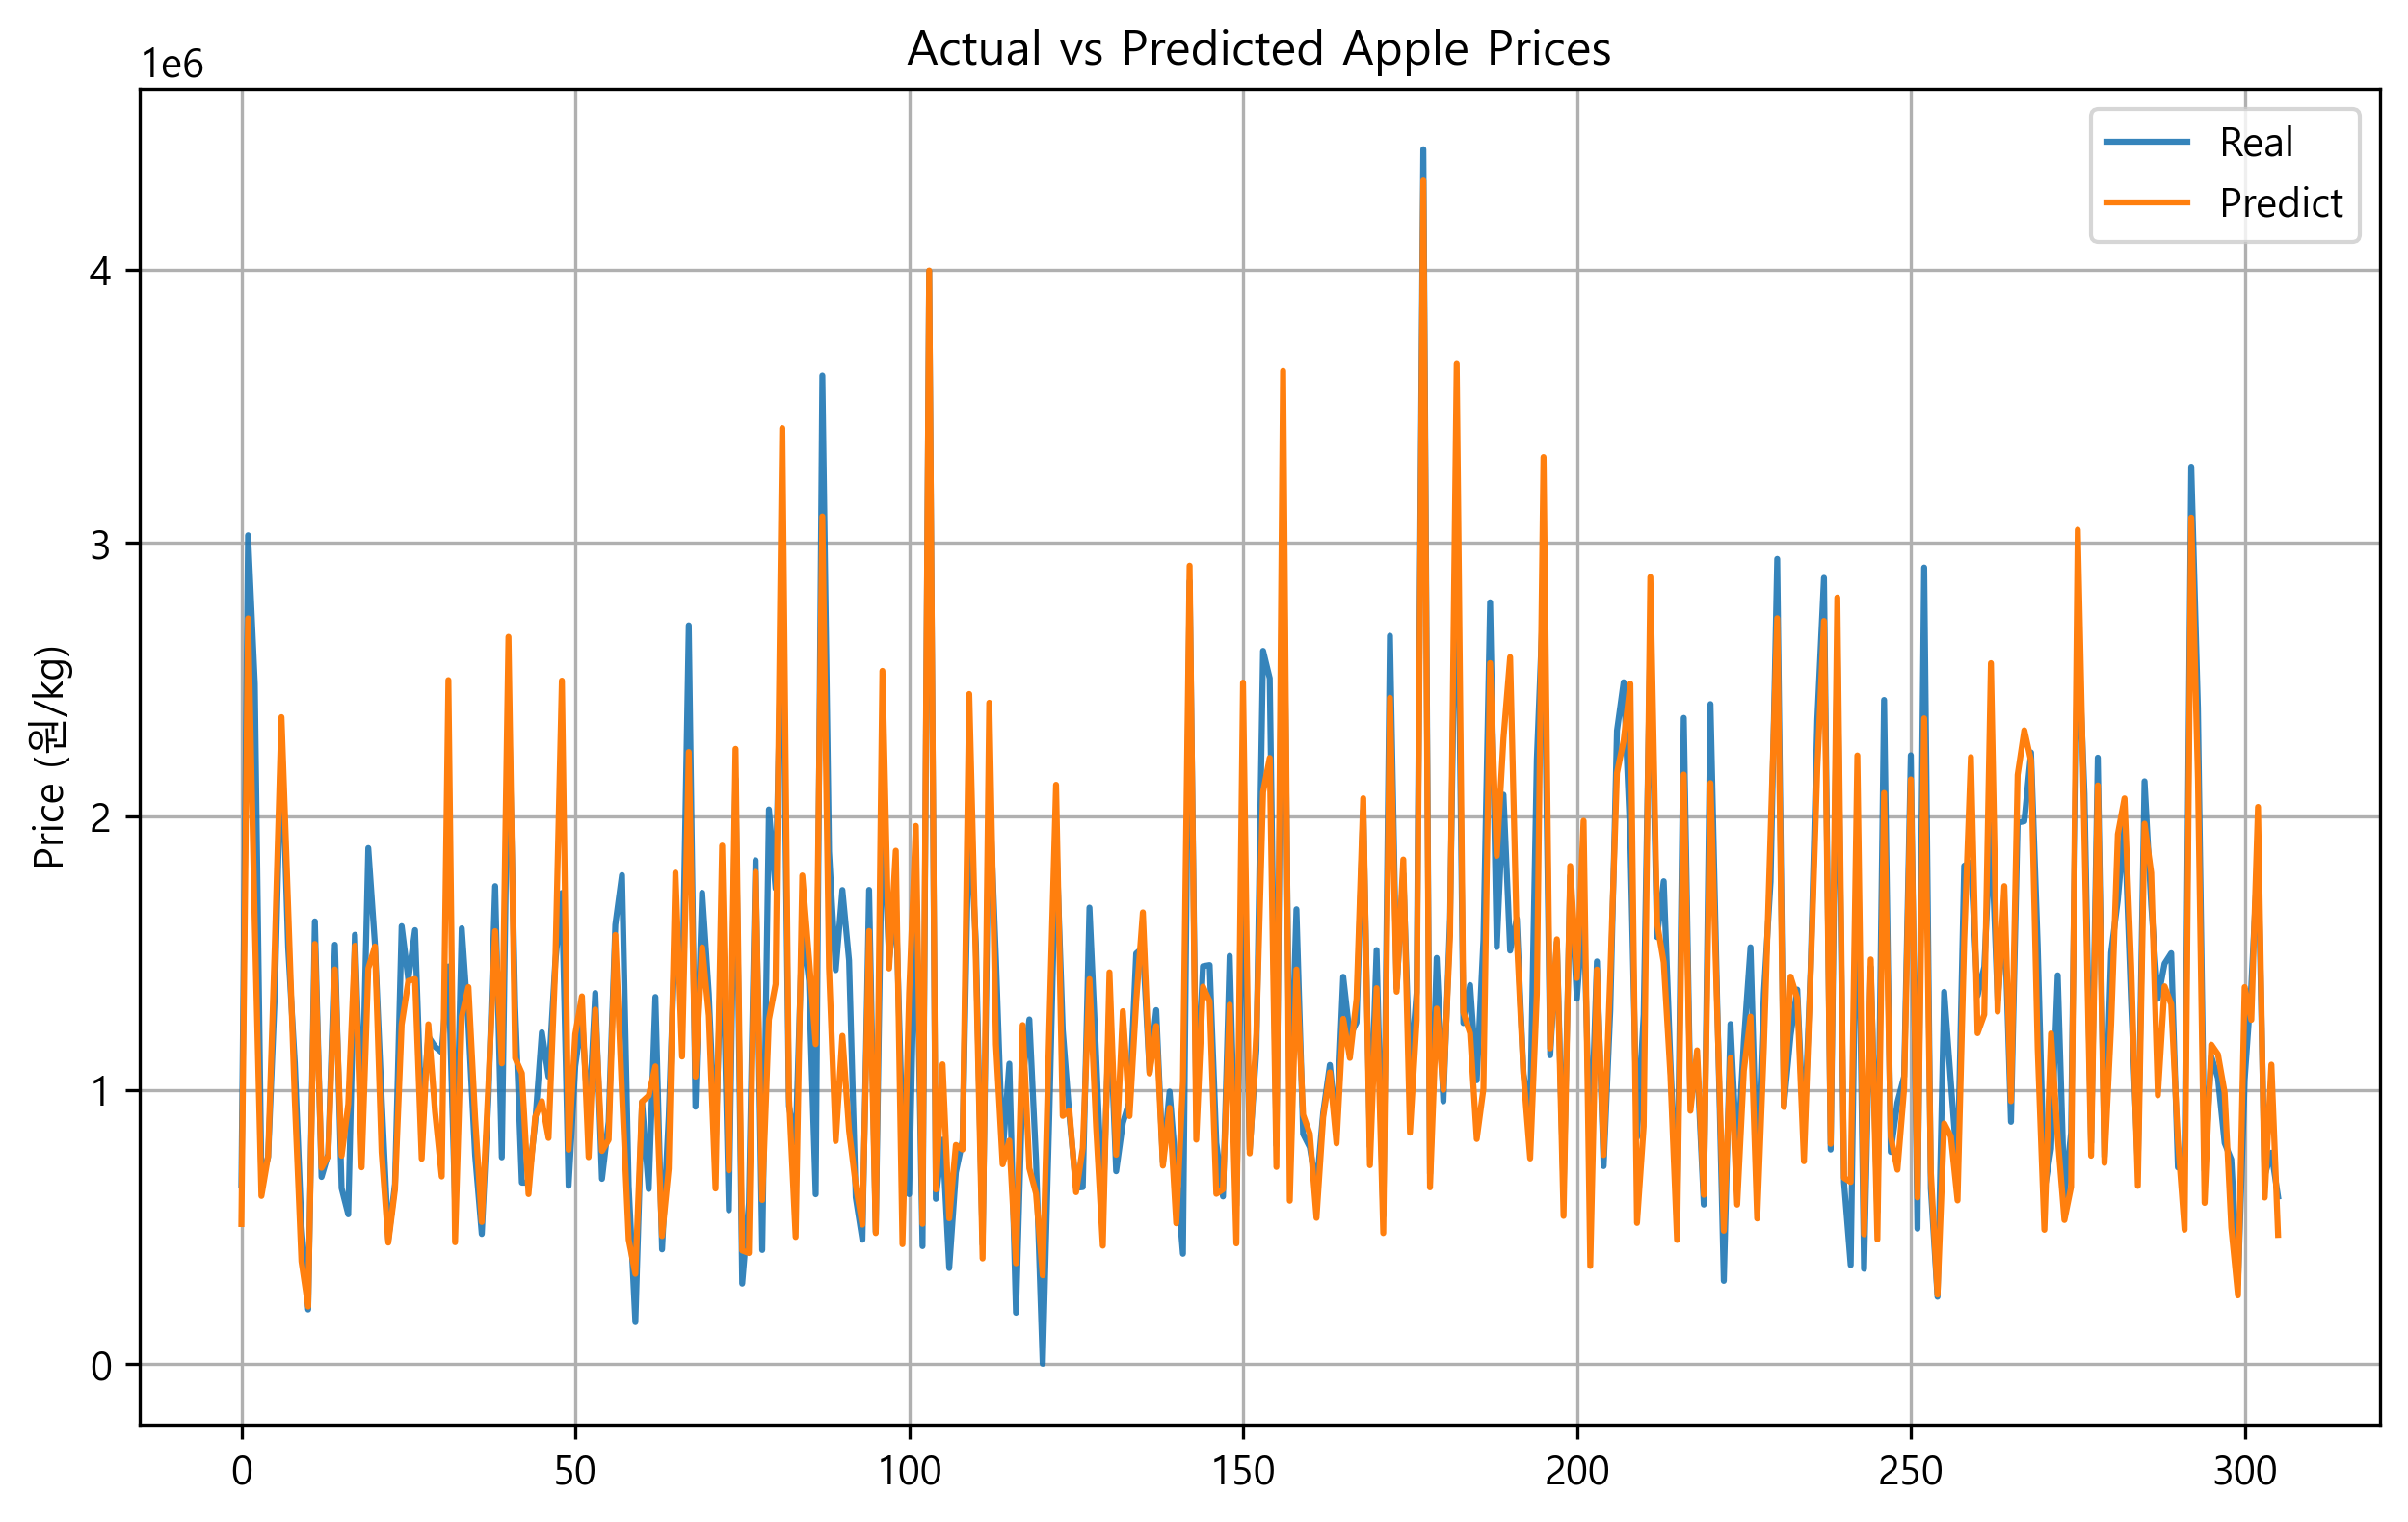

In [7]:
# Train
train_predictions = model.predict(X_train)
train_predictions = scaler.inverse_transform(np.concatenate((train_predictions, np.zeros((train_predictions.shape[0], len(feature_columns)))), axis=1))[:, 0]
Y_train_true = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], len(feature_columns)))), axis=1))[:, 0]

train_mse = mean_squared_error(Y_train_true, train_predictions)
train_mae = mean_absolute_error(Y_train_true, train_predictions)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(Y_train_true, train_predictions)

print("Train MSE: ", train_mse)
print("Train MAE: ", train_mae)
print("Train RMSE: ", train_rmse)
print("Train R²: ", train_r2)


# Test 
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], len(feature_columns)))), axis=1))[:, 0]
Y_test_true = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], len(feature_columns)))), axis=1))[:, 0]

test_mse = mean_squared_error(Y_test_true, test_predictions)
test_mae = mean_absolute_error(Y_test_true, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(Y_test_true, test_predictions)

print("Test MSE: ", test_mse)
print("Test MAE: ", test_mae)
print("Test RMSE: ", test_rmse)
print("Test R²: ", test_r2)

# 시각화 (Test 결과)
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(np.array(Y_test_true).reshape(-1, 1), alpha=0.9, label='Real')
plt.plot(np.array(test_predictions).reshape(-1, 1), label='Predict')
plt.title('Actual vs Predicted Apple Prices')
plt.ylabel('Price (원/kg)')
plt.legend()
plt.grid(True)
plt.show()

하이퍼파라미터 튜닝

Fitting 3 folds for each of 162 candidates, totalling 486 fits


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best: 0.832441 using {'batch_size': 32, 'epochs': 150, 'model__dropout_rate': 0.1, 'model__lstm_units': 100, 'model__optimizer': 'adam'}
Test MSE:  45754288892.31562
Test MAE:  150366.59452243152
Test RMSE:  213902.52194005478
Test R²:  0.9154305607947356


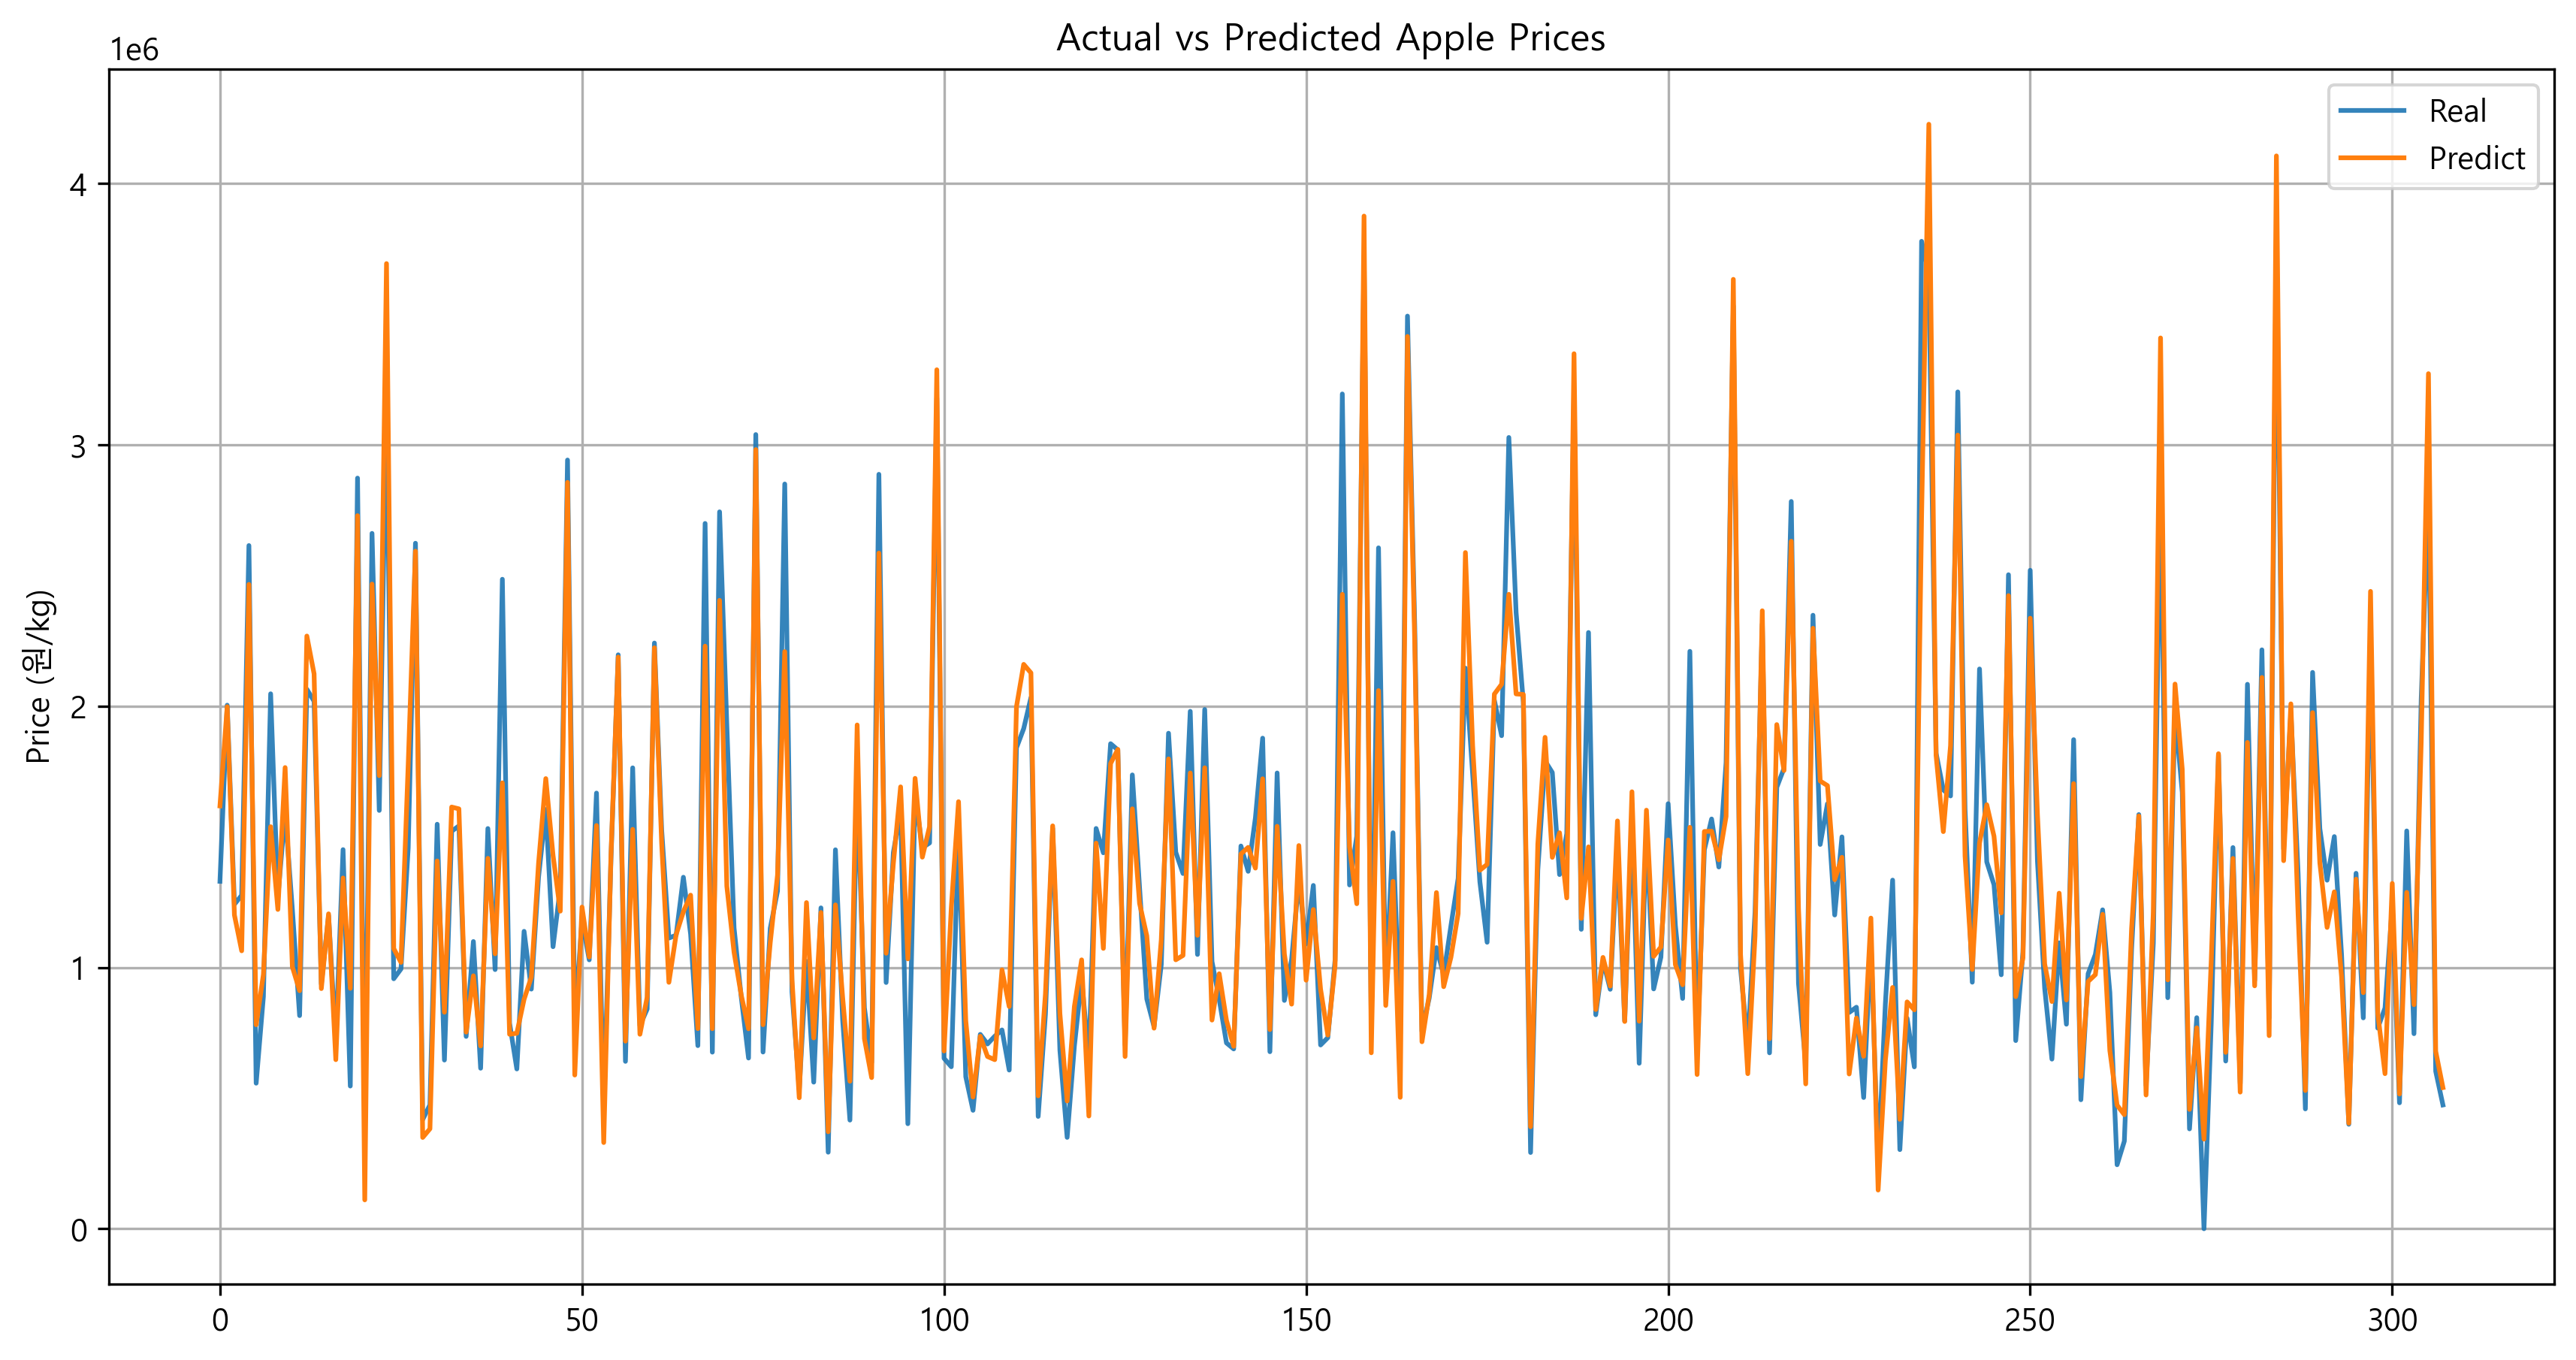

In [ ]:

# 모델 생성 함수 수정
def create_model(lstm_units=50, dropout_rate=0.2,optimizer='adam'):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units // 2, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# 하이퍼파라미터 그리드 설정
param_grid = {
    'batch_size': [32, 64, 128],  # 배치 크기
    'epochs': [50, 100, 150],  # 에폭 수
    'model__lstm_units': [50, 100, 150], 
    'model__dropout_rate': [0.1, 0.2, 0.3], 
    'model__optimizer': ['adam', 'rmsprop']
}

# KerasRegressor로 모델 래핑
model = KerasRegressor(build_fn=create_model, verbose=0)

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[feature_columns + target_columns])

time_step = 7
X, Y = create_dataset(scaled_data, time_step)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# 하이퍼파라미터 그리드 서치 실행
grid_search_result = grid_search.fit(X_train, Y_train)

print("Best: %f using %s" % (grid_search_result.best_score_, grid_search_result.best_params_))

# 최적 모델 추출
best_model = grid_search_result.best_estimator_

test_predictions = best_model.predict(X_test)

test_predictions = scaler.inverse_transform(np.concatenate((test_predictions.reshape(-1, 1), np.zeros((test_predictions.shape[0], len(feature_columns)))), axis=1))[:, 0]
Y_test_true = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], len(feature_columns)))), axis=1))[:, 0]

mse = mean_squared_error(Y_test_true, test_predictions)
mae = mean_absolute_error(Y_test_true, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test_true, test_predictions)

print("Test MSE: ", mse)
print("Test MAE: ", mae)
print("Test RMSE: ", rmse)
print("Test R²: ", r2)

plt.figure(figsize=(14, 7), dpi=300)
plt.plot(np.array(Y_test_true).reshape(-1, 1), alpha=0.9, label='Real')
plt.plot(np.array(test_predictions).reshape(-1, 1), label='Predict')
plt.title('Actual vs Predicted Apple Prices')
plt.ylabel('Price (원/kg)')
plt.legend()
plt.grid(True)
plt.show()